## P9.4.1
-----

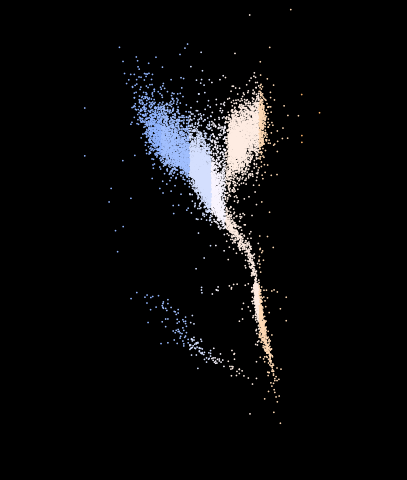

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

WIDTH, HEIGHT = 6, 8

df = pd.read_csv(
    filepath_or_buffer="C:/Users/Arjun Sarao/Learn-Scientific-Programming-with-Python-Solutions/LSPwP_accompanying_files/hygdata_v3-abridged.csv"
)

star_rgbs = (
    "#ffffff",
    "#FFB56C",
    "#FFDAB5",
    "#FFEDE3",
    "#F9F5FF",
    "#D5E0FF",
    "#A2C0FF",
    "#92B5FF",
)
color_mapping = {
    "M": "#FFB56C",
    "K": "#FFDAB5",
    "G": "#FFEDE3",
    "F": "#F9F5FF",
    "A": "#D5E0FF",
    "B": "#A2C0FF",
    "O": "#92B5FF",
}


df["T"] = 4600 * (1.0 / (0.92 * df["ci"] + 1.7) + 1.0 / (0.92 * df["ci"] + 0.62))
df["T"].fillna(0, inplace=True)

df["cidx"] = pd.cut(
    df["T"],
    bins=(0, 2400, 3700, 5200, 6000, 7500, 10000, 30000),
    labels=list("MKGFABO"),
    right=False,
)
df["rgb"] = df["cidx"].map(color_mapping)


fig, ax = plt.subplots(figsize=(WIDTH, HEIGHT), facecolor="k")
ax.set_facecolor("k")
ax.scatter(df["T"], df["lum"], s=0.5, c=df["rgb"])
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(1.0e-6, 1.0e5)
ax.set_xlim(30000, 1000)
ax.set_xticks([30000, 10000, 5000, 3000, 1000])
ax.get_xaxis().set_major_formatter(ScalarFormatter())
ax.set_xlabel("Temperature /K")
ax.set_ylabel("Luminosity relative to Sun")

plt.show()


## P9.4.2
-----

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

eta0 = 1.859e-5  # air viscosity, kg.m-1.s-1
b = 7.88e-3
rho_air = 1.17  # air density, kg.m-3
rho_oil = 917.3  # oil density, kg.m-3
r_hop = rho_oil - rho_air
p = 100.82e3
g = 9.803  # acceleration due to gravity, m.s-2
d = 11.09e-3  # rise/fall distance, m
E = -322.1e3


def get_eta(a: float) -> float:
    return eta0 / (1 + b / a / p)


def get_a(tg: float) -> float:
    vg = -d / tg
    c = b / p
    a - (-c + np.sqrt(c**2 - 18 * eta0 * vg / r_hop / g)) / 2
    return a


df = pd.read_csv(
    filepath_or_buffer="C:/Users/Arjun Sarao/Learn-Scientific-Programming-with-Python-Solutions/LSPwP_accompanying_files/eg10-millikan-data.txt",
    delim_whitespace=True,
    index_col=[0, 1],
)

for drop in df.index.levels[0]:
    drop_df = df.loc[drop].T
    drop_df.index = drop_df.index.str.slice(0, 2)
    tg = drop_df.loc["tg"].values.mean()
    te = drop_df.loc["te"].mean()
    a = get_a(tg)
    eta = get_eta(a)
    q = 6.0 * np.pi * eta * a * d / E * (1.0 / tg + 1.0 / te)
    df.loc[drop, "q"] = q.values
sorted_q = sorted(-df.loc[:, "q"])
dq = np.diff(sorted_q)
e_estimate = dq[(dq > 1.0e-19) & (dq < 2.0e-19)].mean()
df["N"] = (df["q"] / e_estimate).astype(int)
e = (df["q"] / df["N"]).mean()
print(f"The estimated value for e is is {e}")


The estimated value for e is is 1.520452852184989e-19


## P9.4.3
-----

In [46]:
import pandas as pd

weather_data = pd.read_csv(
    filepath_or_buffer="C:/Users/Arjun Sarao/Learn-Scientific-Programming-with-Python-Solutions/LSPwP_accompanying_files/weather-raw.csv",
    names=[
        "Timestamp",
        "Temperature",
        "Humidity",
        "Dew Point",
        "Pressure",
        "Mean Wind Speed",
        "Average Wind Bearing",
        "Sunshine",
        "Rainfall",
        "Max Wind Speed",
    ],
)
weather_data.index = pd.to_datetime(weather_data["Timestamp"])

scalings = {
    10: ["Temperature", "Dew Point", "Mean Wind Speed", "Max Wind Speed"],
    100: "Sunshine",
    1000: "Rainfall",
}
for fac, cols in scalings.items():
    weather_data[cols] = weather_data.loc(axis=1)[cols] / fac
# a) Find the most common wind bearing
print(
    f"The most common average wind bearing is: {weather_data['Average Wind Bearing'].mode()[0]} degrees."
)

# b) Find the fastest wind speed
weather_data.loc[
    weather_data["Max Wind Speed"] > 100, "Max Wind Speed"
] = np.nan  # No way the wind is faster than 100 m/s
idx = weather_data["Max Wind Speed"].idxmax()
wind_max = weather_data.loc[idx]["Max Wind Speed"]
print(f"The fastest wind speed is: {wind_max} m/s. It occurred at {idx}.")

# c) Find the year with the sunniest June
sunshine_monthly = weather_data["Sunshine"].resample("M").sum()
idx = sunshine_monthly[sunshine_monthly.index.month == 6].idxmax()
print(
    f"The year with the sunniest June is: {idx.year}. It had {sunshine_monthly[idx]} hours of sunshine."
)

# d) Find the day with the most rainfall
rainfall_daily = weather_data["Rainfall"].resample("D").sum()
idx = rainfall_daily.idxmax()
print(
    f"The day with the most rainfall is: {idx}. It had {rainfall_daily[idx]} mm of rainfall."
)

# e) Find the coldest temperature
temperature_daily = weather_data["Temperature"].resample("D").min()
idx = temperature_daily.idxmin()
print(
    f"The coldest temperature was: {temperature_daily[idx]} degrees. It occurred on {idx}."
)  # Ok so I'm from Canada so a temperature of -40 degrees is not unheadd of. Could be too low for the UK though.

# Funny how the sunniest days and the days with the most rainfall are in recent years...


The most common average wind bearing is: 180.0 degrees.
The fastest wind speed is: 96.0 m/s. It occurred at 2016-01-08 16:00:00.
The year with the sunniest June is: 2022. It had 258.64 hours of sunshine.
The day with the most rainfall is: 2021-08-08 00:00:00. It had 333.31 mm of rainfall.
The coldest temperature was: -40.0 degrees. It occurred on 2015-11-22 00:00:00.


## P9.4.4
-----

In [50]:
import pandas as pd

gold_data = pd.read_csv(
    filepath_or_buffer="C:/Users/Arjun Sarao/Learn-Scientific-Programming-with-Python-Solutions/LSPwP_accompanying_files/gold.txt",
    delim_whitespace=True,
    index_col=0,
    usecols=[0, 1],
    parse_dates=True,
)
snp = pd.read_csv(
    filepath_or_buffer="C:/Users/Arjun Sarao/Learn-Scientific-Programming-with-Python-Solutions/LSPwP_accompanying_files/SNP.csv",
    parse_dates=True,
    index_col=0,
)
btc = pd.read_csv(
    filepath_or_buffer="C:/Users/Arjun Sarao/Learn-Scientific-Programming-with-Python-Solutions/LSPwP_accompanying_files/BTC.csv",
    parse_dates=True,
    index_col=0,
)

gold_data["holding"] = 100 / gold_data["Price"]
snp["holding"] = 100 / snp["Open"]
btc["holding"] = 100 / btc["BTC-USD"]

final_date = "2020-07-01"
total_btc = btc["holding"][:final_date].sum()
total_gold = gold_data["holding"][:final_date].sum()
total_snp = snp["holding"][:final_date].sum()

print(f"Gold Investment: ${total_gold * gold_data.loc[final_date]['Price']:.2f} USD.")
print(f"SNP Investment: ${total_snp * snp.loc[final_date]['Open']:.2f} USD.")
print(f"BTC Investment: ${total_btc * btc.loc[final_date]['BTC-USD']:.2f} USD.")


Gold Investment: $17433.58 USD.
SNP Investment: $21739.46 USD.
BTC Investment: $529701861.66 USD.
